In [2]:
# Инструменты для изучения данных
import pandas as pd
import numpy as np
from collections import Counter
import statistics

import warnings
warnings.simplefilter("ignore")

# Графики
import seaborn as sns
import matplotlib.pyplot as plt

# Модели
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
# from pytorch_tabnet.tab_model import TabNetClassifier
from catboost import CatBoostClassifier

# Инструменты для обработки данных
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, KFold
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import RobustScaler, MinMaxScaler, Normalizer
from sklearn.preprocessing import LabelEncoder

# Скоринг
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

In [3]:
# GH_data - кишечная палочка
gh_data = pd.read_csv('data/e-coli-data.csv')

# ITMO_data - кисломолочные бактерии
itmo_data = pd.read_csv('data/molochka.csv')

itmo_data.sample(3)

,Compound,0.02 V,0.1 V,0.5 V,1.0 V,5.0 V
2873,10^5,9.449850e-09,1.561350e-10,-1.475450e-07,0.000001,0.000103
115,10^4,-1.414370e-06,-4.952860e-07,1.366080e-06,0.000001,0.000942
5854,10^6,3.300540e-06,4.397760e-07,-1.759890e-06,-0.000003,0.000220


___

# Закодируем значения `Compound`

In [4]:
le_g = LabelEncoder()
le_i = LabelEncoder()

gh_data['Compound'] = le_g.fit_transform(gh_data['Compound'])
itmo_data['Compound'] = le_i.fit_transform(itmo_data['Compound'])

gh_data.sample(3)

,Compound,0.02 V,0.1 V,0.5 V,1 V,5 V
1205,8,-5.145230e-06,-1.516330e-05,-0.000088,-0.000289,-0.00948
24790,4,1.766970e-07,6.452300e-07,0.000005,0.000013,0.00492
52249,3,-1.400000e-06,-3.270000e-06,-0.000015,-0.000066,-0.00674


In [5]:
itmo_data.sample(3)

,Compound,0.02 V,0.1 V,0.5 V,1.0 V,5.0 V
13708,5,-1.770890e-06,-1.013490e-08,0.000007,0.000037,0.00260
8723,3,3.868270e-07,-1.152040e-06,-0.000014,-0.000081,-0.00326
9999,4,-7.293840e-08,-1.919330e-07,-0.000002,-0.000042,-0.00309


In [6]:
print(le_i.classes_)
print(le_g.classes_)

['10^4' '10^5' '10^6' '10^7' '10^8' 'control']
['0 (CFU/ml)' '10² (CFU/ml)' '10³ (CFU/ml)' '10⁴ (CFU/ml)' '10⁵ (CFU/ml)'
 '10⁶ (CFU/ml)' '10⁷ (CFU/ml)' '10⁸ (CFU/ml)' '10⁹ (CFU/ml)']


___

# Распределение `Compound` до `under_sampling`-а

## Почему `under_sampling`?

- Синтетические данные могут повредить точности модели
- Дискриманция классов может привести к потери точности в определении других Компаундов

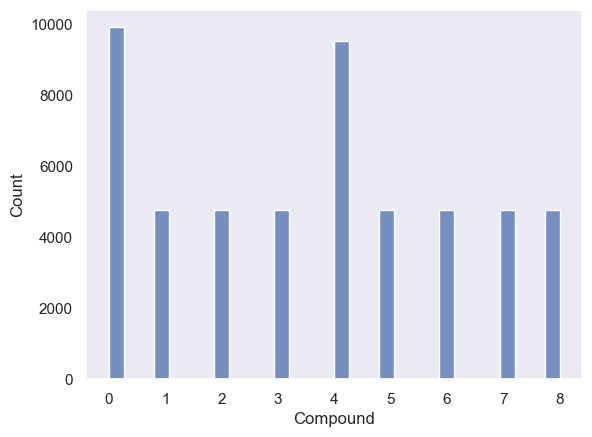

In [7]:
sns.set_theme(style='dark')
sns.histplot(gh_data['Compound']);

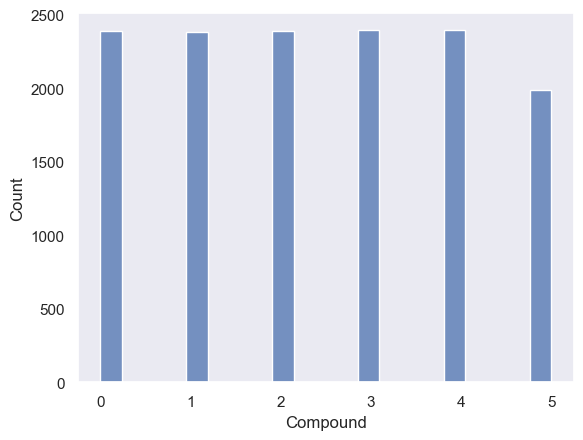

In [8]:
sns.histplot(itmo_data['Compound']);

___

# После `under_sampling`-а

In [9]:
# Для GitHub данных

Xg = gh_data.drop(columns=['Compound'])
yg = gh_data['Compound']

Xg_train, Xg_test, yg_train, yg_test = train_test_split(Xg, yg, test_size=0.2, random_state=1)

under_sampler = RandomUnderSampler(random_state=1)
Xg_train, yg_train = under_sampler.fit_resample(Xg_train, yg_train)
print("Разделение по классам после UnderSampling:", Counter(yg_train))

Разделение по классам после UnderSampling: Counter({0: 3747, 1: 3747, 2: 3747, 3: 3747, 4: 3747, 5: 3747, 6: 3747, 7: 3747, 8: 3747})


In [10]:
# Для ITMO данных

Xi = itmo_data.drop(columns=['Compound'])
yi = itmo_data['Compound']

Xi_train, Xi_test, yi_train, yi_test = train_test_split(Xi, yi, test_size=0.2, random_state=1)

under_sampler = RandomUnderSampler(random_state=1)
Xi_train, yi_train = under_sampler.fit_resample(Xi_train, yi_train)
print("Разделение по классам после UnderSampling:", Counter(yi_train))

Разделение по классам после UnderSampling: Counter({0: 1588, 1: 1588, 2: 1588, 3: 1588, 4: 1588, 5: 1588})


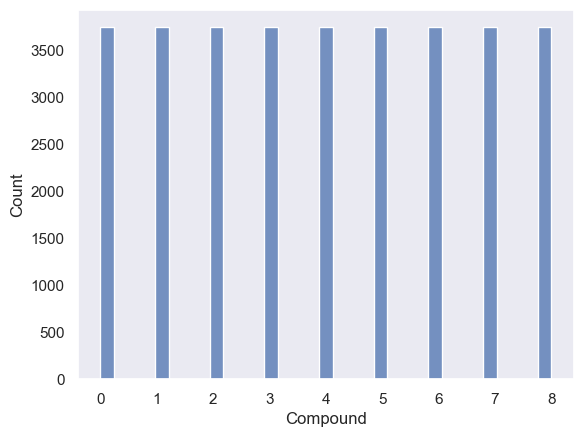

In [11]:
sns.histplot(yg_train);

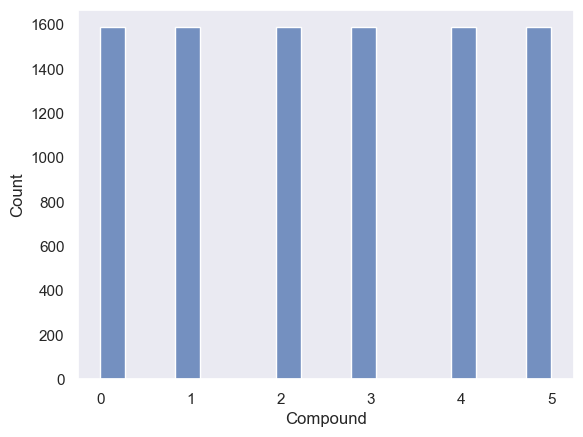

In [12]:
sns.histplot(yi_train);

In [13]:
# MinMaxScaled Data

mms_g = MinMaxScaler()
mms_i = MinMaxScaler()

mms_g.fit(Xg_train)
Xg_mms_train = mms_g.transform(Xg_train)
Xg_mms_test = mms_g.transform(Xg_test)

mms_i.fit(Xi_train)
Xi_mms_train = mms_i.transform(Xi_train)
Xi_mms_test = mms_i.transform(Xi_test)

In [14]:
# RobustScaled Data

rs_g = RobustScaler()
rs_i = RobustScaler()

rs_g.fit(Xg_train)
Xg_rs_train = rs_g.transform(Xg_train)
Xg_rs_test = rs_g.transform(Xg_test)

rs_i.fit(Xi_train)
Xi_rs_train = rs_i.transform(Xi_train)
Xi_rs_test = rs_i.transform(Xi_test)

In [15]:
# Normalized Data

ner_g = Normalizer()
ner_i = Normalizer()

ner_g.fit(Xg_train)
Xg_ner_train = ner_g.transform(Xg_train)
Xg_ner_test = ner_g.transform(Xg_test)

ner_i.fit(Xi_train)
Xi_ner_train = ner_i.transform(Xi_train)
Xi_ner_test = ner_i.transform(Xi_test)

In [20]:
scaler = MinMaxScaler()

Xg_scaled = scaler.fit_transform(Xg)

___

## Список моделей для проверки:

- **Random Forest Classifiers (RF) / Extra Trees Classifier (ET)** : _"Bacterial species identification from MALDI-TOF mass spectra 
through data analysis and machine learning"_

- **Support Vector Machines (SVM)** : _"Bacterial species identification from MALDI-TOF mass spectra 
through data analysis and machine learning"_

- **Artificial Neural Networks (ANN)** : _"Towards large-scale FAME-based bacterial species identification using 
machine learning techniques"_

- **Catboost (CBC)**: _Логическое продолжение RF_

- **Logistic Regression (LR)** : _Проверка на линейную зависимость между факторами_


## Список метрик для оценки:

- Accuracy
- Recall
- Precision
- F1-score

## Список методов предобработки данных:

- RobustScaler
- Normalizer
- MinMaxScaler

___

# Тренируем модели

In [18]:
def train_model(model, X_train, y_train, X_test, y_test):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print('#', model, '\n',
         '\b_________________________',
         '\nAccuracy_score:', accuracy_score(y_test, y_pred),
         '\nRecall:', recall_score(y_test, y_pred, average='macro'),
         '\nPrecision:', precision_score(y_test, y_pred, average='macro'),
         '\nF1-score:', f1_score(y_test, y_pred, average='macro'), '\n')

In [29]:
model_list = [RandomForestClassifier(), ExtraTreesClassifier(), SVC(), LogisticRegression()]

___

# Модели без предобработки. `Кишечная палочка`

In [20]:
for mod in model_list:
    train_model(mod, Xg_train, yg_train, Xg_test, yg_test)

# RandomForestClassifier() 
_________________________ 
Accuracy_score: 0.9801594835769888 
Recall: 0.9793486420547084 
Precision: 0.9773504443936645 
F1-score: 0.9782649197443831 

# ExtraTreesClassifier() 
_________________________ 
Accuracy_score: 0.9961078412758686 
Recall: 0.9964615660206948 
Precision: 0.9957133367988611 
F1-score: 0.9960815451371506 

# SVC() 
_________________________ 
Accuracy_score: 0.16185684450351243 
Recall: 0.16752982662221907 
Precision: 0.35313562746850036 
F1-score: 0.15814552806529766 

# LogisticRegression() 
_________________________ 
Accuracy_score: 0.09037402696031897 
Recall: 0.1104838877342304 
Precision: 0.13431206397675668 
F1-score: 0.04358809746958217 



# `Кисломолочные бактерии`

In [21]:
for mod in model_list:
    train_model(mod, Xi_train, yi_train, Xi_test, yi_test)

# RandomForestClassifier() 
_________________________ 
Accuracy_score: 0.9856579419146647 
Recall: 0.9849513261494982 
Precision: 0.9857871951953451 
F1-score: 0.9853143165475774 

# ExtraTreesClassifier() 
_________________________ 
Accuracy_score: 0.9953388311222661 
Recall: 0.9952045645434763 
Precision: 0.9953896442213255 
F1-score: 0.9952927824476613 

# SVC() 
_________________________ 
Accuracy_score: 0.23664395840803154 
Recall: 0.22979880531364294 
Precision: 0.238090278701913 
F1-score: 0.19558669287135586 

# LogisticRegression() 
_________________________ 
Accuracy_score: 0.16493366798135534 
Recall: 0.15873067010309277 
Precision: 0.05509761462325907 
F1-score: 0.08109921705906939 



___

# MinMaxScaler
# `Кишечная палочка`

In [22]:
for mod in model_list:
    train_model(mod, Xg_mms_train, yg_train, Xg_mms_test, yg_test)

# RandomForestClassifier() 
_________________________ 
Accuracy_score: 0.9888931080311373 
Recall: 0.9895356768743605 
Precision: 0.9874028280933196 
F1-score: 0.9884281073383338 

# ExtraTreesClassifier() 
_________________________ 
Accuracy_score: 0.9960129105752801 
Recall: 0.9966023676573088 
Precision: 0.9955266332327 
F1-score: 0.9960574359232552 

# SVC() 
_________________________ 
Accuracy_score: 0.534459844313651 
Recall: 0.565165888100203 
Precision: 0.5410193307919567 
F1-score: 0.5186759930536694 

# LogisticRegression() 
_________________________ 
Accuracy_score: 0.3645338902601101 
Recall: 0.36437920171206617 
Precision: 0.3709768039533718 
F1-score: 0.3653529248600878 



# `Кисломолочка`

In [23]:
for mod in model_list:
    train_model(mod, Xi_mms_train, yi_train, Xi_mms_test, yi_test)

# RandomForestClassifier() 
_________________________ 
Accuracy_score: 0.9913947651487989 
Recall: 0.9911028332841543 
Precision: 0.9914189789174784 
F1-score: 0.9912517595002875 

# ExtraTreesClassifier() 
_________________________ 
Accuracy_score: 0.9956973825743994 
Recall: 0.9955517867656986 
Precision: 0.9957412065469885 
F1-score: 0.9956418111048629 

# SVC() 
_________________________ 
Accuracy_score: 0.7637145930441018 
Recall: 0.7498484631638119 
Precision: 0.7832342360611467 
F1-score: 0.7291531688090478 

# LogisticRegression() 
_________________________ 
Accuracy_score: 0.6367873789888849 
Recall: 0.6245171149332994 
Precision: 0.6105879335712519 
F1-score: 0.6021001944286727 



___

# Robust Scaler
# `Кишечная палочка`

In [24]:
for mod in model_list:
    train_model(mod, Xg_rs_train, yg_train, Xg_rs_test, yg_test)

# RandomForestClassifier() 
_________________________ 
Accuracy_score: 0.9893677615340801 
Recall: 0.9899470812325366 
Precision: 0.988287078048435 
F1-score: 0.9890980228350494 

# ExtraTreesClassifier() 
_________________________ 
Accuracy_score: 0.9958230491741029 
Recall: 0.9963115671685325 
Precision: 0.9954202625656018 
F1-score: 0.9958591944564803 

# SVC() 
_________________________ 
Accuracy_score: 0.63014999050693 
Recall: 0.6590726148715544 
Precision: 0.6502234839824834 
F1-score: 0.6297749112372623 

# LogisticRegression() 
_________________________ 
Accuracy_score: 0.3783937725460414 
Recall: 0.3754922358171513 
Precision: 0.38672066428949514 
F1-score: 0.37939142371746015 



# `Кисломолочка`

In [25]:
for mod in model_list:
    train_model(mod, Xi_rs_train, yi_train, Xi_rs_test, yi_test)

# RandomForestClassifier() 
_________________________ 
Accuracy_score: 0.9921118680530656 
Recall: 0.9918053279173619 
Precision: 0.9921823270751285 
F1-score: 0.9919791077474917 

# ExtraTreesClassifier() 
_________________________ 
Accuracy_score: 0.9946217282179993 
Recall: 0.9944437020313383 
Precision: 0.9947064509548156 
F1-score: 0.9945640674716878 

# SVC() 
_________________________ 
Accuracy_score: 0.8085335245607744 
Recall: 0.7980179974270646 
Precision: 0.8166397661823647 
F1-score: 0.7909901367368914 

# LogisticRegression() 
_________________________ 
Accuracy_score: 0.6457511652922194 
Recall: 0.6350743905287494 
Precision: 0.6245571418214846 
F1-score: 0.6209302580169954 



___

# Normalizer

# `Кишечная палочка`

In [26]:
for mod in model_list:
    train_model(mod, Xg_ner_train, yg_train, Xg_ner_test, yg_test)

# RandomForestClassifier() 
_________________________ 
Accuracy_score: 0.9267134991456237 
Recall: 0.930168395825761 
Precision: 0.9187462111572687 
F1-score: 0.9234264590906179 

# ExtraTreesClassifier() 
_________________________ 
Accuracy_score: 0.9363014999050693 
Recall: 0.939359042523737 
Precision: 0.929413942274216 
F1-score: 0.9334650687057641 

# SVC() 
_________________________ 
Accuracy_score: 0.2221378393772546 
Recall: 0.18124261482039522 
Precision: 0.330578199118309 
F1-score: 0.18024804952390627 

# LogisticRegression() 
_________________________ 
Accuracy_score: 0.28830453768748815 
Recall: 0.2761165218703987 
Precision: 0.3144756453360649 
F1-score: 0.27760480349825783 



# `Кисломолочка`

In [27]:
for mod in model_list:
    train_model(mod, Xi_ner_train, yi_train, Xi_ner_test, yi_test)

# RandomForestClassifier() 
_________________________ 
Accuracy_score: 0.9408390103979921 
Recall: 0.9389400840564428 
Precision: 0.9407308365733814 
F1-score: 0.9395120857888166 

# ExtraTreesClassifier() 
_________________________ 
Accuracy_score: 0.95016134815346 
Recall: 0.9486750163583496 
Precision: 0.9496188108268554 
F1-score: 0.9490059043836175 

# SVC() 
_________________________ 
Accuracy_score: 0.23054858372176407 
Recall: 0.23521684220501027 
Precision: 0.3082372450367987 
F1-score: 0.19001291197906287 

# LogisticRegression() 
_________________________ 
Accuracy_score: 0.27465041233417 
Recall: 0.27279498267107405 
Precision: 0.3415422637349723 
F1-score: 0.23909267474311513 



___

# Графики точностей по f1-score для `RobustScaler`, Кишечная палочка

In [35]:
f1_scores = []

for model in model_list:
    model.fit(Xg_rs_train, yg_train)
    f1_scores.append(f1_score(yg_test, model.predict(Xg_rs_test), average='macro'))

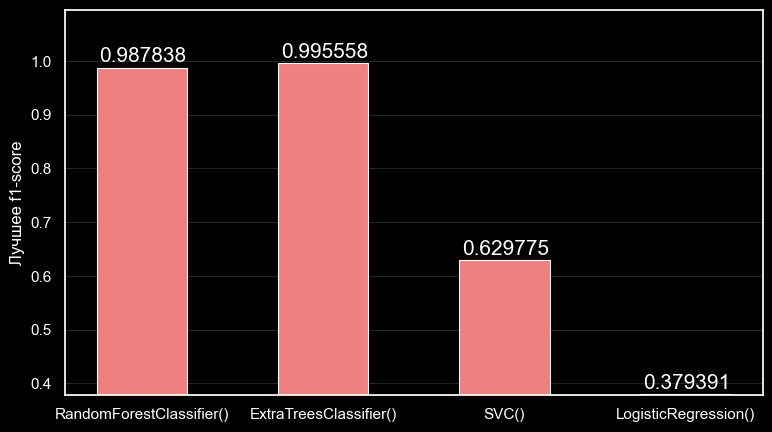

In [168]:
plt.style.use(['dark_background'])
plt.figure(figsize=(9, 5))

plt.bar(range(len(f1_scores)), f1_scores, color='lightcoral', width=0.5, edgecolor='white', linewidth=0.8)

for i, v in enumerate(f1_scores):
    plt.text(i-0.234, v+0.01, str(round(v, 6)), fontsize=15)

plt.ylabel('Лучшее f1-score')
plt.ylim(min(f1_scores)-0.001, max(f1_scores)+0.1)
plt.xticks([i for i in range(len(f1_scores))], model_list)
plt.grid(color='grey', linewidth=0.7, axis='y', alpha=0.3)

plt.show()

In [21]:
model = ExtraTreesClassifier()

values = cross_val_score(model, Xg_scaled, yg, cv=KFold(shuffle=True))

print(values)
print(statistics.mean(values))

[0.99724701 0.99677236 0.99819632 0.99838602 0.99848096]
0.9978165344026858


In [22]:
model = RandomForestClassifier()

values = cross_val_score(model, Xg_scaled, yg, cv=KFold(shuffle=True))

print(values)
print(statistics.mean(values))

[0.99259541 0.9916461  0.9928802  0.99031615 0.9925947 ]
0.9920065105534766


___

# Тюнинг "Caboost Classifier" 

In [17]:
clf =  CatBoostClassifier(task_type='GPU', bootstrap_type='Poisson', eval_metric='Accuracy', loss_function='MultiClass')

grid = {
        'depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        'learning_rate': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
        'l2_leaf_reg': [1, 20, 50, 100],
        'iterations': [100, 300, 600, 1000, 5000],
        'early_stopping_rounds': [50],
        'verbose': [250]
    }

In [ ]:
clf.grid_search(grid, Xg_mms_train, yg_train, plot=False, cv=3, shuffle=True, stratified=True, refit=True, verbose=100)

# Лучшие параметры

```python
task_type='GPU',
bootstrap_type='Poisson',
eval_metric='Accuracy',
loss_function='MultiClass',
depth=8,
od_wait=50,
l2_leaf_reg=1,
iterations=5000,
learning_rate=0.1,
verbose=250
```

In [47]:
clf =  CatBoostClassifier(task_type='GPU',
                          bootstrap_type='Poisson',
                          eval_metric='Accuracy',
                          loss_function='MultiClass',
                          depth=8,
                          od_wait=50,
                          l2_leaf_reg=1,
                          iterations=5000,
                          learning_rate=0.1,
                          verbose=500)

In [33]:
clf.fit(Xg_mms_train, yg_train)

0:	learn: 0.4794057	total: 12.4ms	remaining: 1m 1s
250:	learn: 0.9511016	total: 3.01s	remaining: 56.9s
500:	learn: 0.9859740	total: 6.03s	remaining: 54.1s
750:	learn: 0.9950182	total: 8.97s	remaining: 50.8s
1000:	learn: 0.9982208	total: 12s	remaining: 48.1s
1250:	learn: 0.9991994	total: 15.1s	remaining: 45.3s
1500:	learn: 0.9994662	total: 18.1s	remaining: 42.3s
1750:	learn: 0.9997924	total: 21.2s	remaining: 39.3s
2000:	learn: 0.9999110	total: 24.2s	remaining: 36.3s
2250:	learn: 0.9999110	total: 27.3s	remaining: 33.3s
2500:	learn: 0.9999110	total: 30.3s	remaining: 30.3s
2750:	learn: 0.9999110	total: 33.2s	remaining: 27.2s
3000:	learn: 0.9999110	total: 36.2s	remaining: 24.1s
3250:	learn: 0.9999110	total: 39.4s	remaining: 21.2s
3500:	learn: 0.9999110	total: 42.4s	remaining: 18.1s
3750:	learn: 0.9999110	total: 45.3s	remaining: 15.1s
4000:	learn: 0.9999110	total: 48.2s	remaining: 12s
4250:	learn: 0.9999110	total: 51.2s	remaining: 9.03s
4500:	learn: 0.9999110	total: 54.2s	remaining: 6.01s
47

In [27]:
f1_score(yg_test, clf.predict(Xg_mms_test), average='macro')

0.9925325729206926

In [29]:
accuracy_score(yg_test, clf.predict(Xg_mms_test))

0.992500474653503

In [ ]:
cross_val_score(clf, Xg_mms_test, yg_test, cv=StratifiedKFold(shuffle=True))

In [11]:
clf =  CatBoostClassifier(task_type='GPU',
                          bootstrap_type='Poisson',
                          eval_metric='Accuracy',
                          loss_function='MultiClass',
                          depth=8,
                          od_wait=50,
                          l2_leaf_reg=1,
                          iterations=5000,
                          learning_rate=0.1,
                          verbose=250)

cross_val_score(clf, Xg, yg, cv=StratifiedKFold(shuffle=True))

0:	learn: 0.4978877	total: 23.8s	remaining: 1d 8h 59m 39s
250:	learn: 0.9482128	total: 26.8s	remaining: 8m 27s
500:	learn: 0.9845730	total: 29.8s	remaining: 4m 27s
750:	learn: 0.9949447	total: 32.8s	remaining: 3m 5s
1000:	learn: 0.9977928	total: 35.9s	remaining: 2m 23s
1250:	learn: 0.9990981	total: 39s	remaining: 1m 56s
1500:	learn: 0.9996440	total: 42s	remaining: 1m 37s
1750:	learn: 0.9998813	total: 44.9s	remaining: 1m 23s
2000:	learn: 0.9999288	total: 47.9s	remaining: 1m 11s
2250:	learn: 0.9999525	total: 50.8s	remaining: 1m 2s
2500:	learn: 0.9999763	total: 53.8s	remaining: 53.7s
2750:	learn: 0.9999763	total: 56.9s	remaining: 46.5s
3000:	learn: 0.9999763	total: 59.9s	remaining: 39.9s
3250:	learn: 0.9999763	total: 1m 2s	remaining: 33.9s
3500:	learn: 0.9999763	total: 1m 5s	remaining: 28.2s
3750:	learn: 0.9999763	total: 1m 8s	remaining: 22.9s
4000:	learn: 0.9999763	total: 1m 11s	remaining: 17.9s
4250:	learn: 0.9999763	total: 1m 14s	remaining: 13.2s
4500:	learn: 0.9999763	total: 1m 17s	re

array([0.99525346, 0.9950636 , 0.9953484 , 0.9925947 , 0.99544289])

___

# TabNet

In [35]:
clf= TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       scheduler_params={"step_size":10, 
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                      )

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [36]:
clf.fit(
    Xg_mms_train, yg_train.values,
    eval_set=[(Xg_mms_train, yg_train.values), (Xg_mms_test, yg_test.values)],
    eval_name=['train', 'test'],
    eval_metric=['balanced_accuracy'],
    max_epochs=450, patience=150,
    batch_size=512, virtual_batch_size=512,
    num_workers=0,
    weights=1,
    drop_last=False
)       

epoch 0  | loss: 1.55536 | train_balanced_accuracy: 0.11025 | test_balanced_accuracy: 0.10939 |  0:00:02s
epoch 1  | loss: 1.02894 | train_balanced_accuracy: 0.2286  | test_balanced_accuracy: 0.23131 |  0:00:05s
epoch 2  | loss: 0.90316 | train_balanced_accuracy: 0.22451 | test_balanced_accuracy: 0.2218  |  0:00:07s
epoch 3  | loss: 0.87086 | train_balanced_accuracy: 0.25967 | test_balanced_accuracy: 0.25759 |  0:00:09s
epoch 4  | loss: 0.79726 | train_balanced_accuracy: 0.30522 | test_balanced_accuracy: 0.3034  |  0:00:12s
epoch 5  | loss: 0.78358 | train_balanced_accuracy: 0.38876 | test_balanced_accuracy: 0.3871  |  0:00:14s
epoch 6  | loss: 0.73225 | train_balanced_accuracy: 0.44486 | test_balanced_accuracy: 0.45026 |  0:00:16s
epoch 7  | loss: 0.73314 | train_balanced_accuracy: 0.64019 | test_balanced_accuracy: 0.64018 |  0:00:19s
epoch 8  | loss: 0.69657 | train_balanced_accuracy: 0.58468 | test_balanced_accuracy: 0.57998 |  0:00:21s
epoch 9  | loss: 0.70116 | train_balanced_accu

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [25]:
clf.fit(
    Xg_ss_train, yg_train.values,
    eval_set=[(Xg_ss_train, yg_train.values), (Xg_ss_test, yg_test.values)],
    eval_name=['train', 'test'],
    eval_metric=['balanced_accuracy'],
    max_epochs=550, patience=150,
    batch_size=512, virtual_batch_size=512,
    num_workers=0,
    weights=1,
    drop_last=False
)       

epoch 0  | loss: 1.60145 | train_balanced_accuracy: 0.2965  | test_balanced_accuracy: 0.2985  |  0:00:02s
epoch 1  | loss: 1.08759 | train_balanced_accuracy: 0.4392  | test_balanced_accuracy: 0.43793 |  0:00:05s
epoch 2  | loss: 0.96516 | train_balanced_accuracy: 0.534   | test_balanced_accuracy: 0.52612 |  0:00:07s
epoch 3  | loss: 0.87986 | train_balanced_accuracy: 0.52383 | test_balanced_accuracy: 0.52983 |  0:00:10s
epoch 4  | loss: 0.81669 | train_balanced_accuracy: 0.58545 | test_balanced_accuracy: 0.58293 |  0:00:12s
epoch 5  | loss: 0.80312 | train_balanced_accuracy: 0.67325 | test_balanced_accuracy: 0.66341 |  0:00:14s
epoch 6  | loss: 0.74086 | train_balanced_accuracy: 0.68642 | test_balanced_accuracy: 0.6818  |  0:00:17s
epoch 7  | loss: 0.73474 | train_balanced_accuracy: 0.65578 | test_balanced_accuracy: 0.6552  |  0:00:19s
epoch 8  | loss: 0.73653 | train_balanced_accuracy: 0.68926 | test_balanced_accuracy: 0.6875  |  0:00:22s
epoch 9  | loss: 0.71389 | train_balanced_accu

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


___

# Попробуем совместить датасеты с концентрациями в один

In [139]:
gh_data = pd.read_csv('data/e-coli-data.csv')
itmo_data = pd.read_csv('data/molochka.csv')

values_to_remove = ['10³ (CFU/ml)', '10² (CFU/ml)', '10⁹ (CFU/ml)']

gh_data.drop(gh_data[gh_data['Compound'].isin(values_to_remove)].index, inplace=True)
name_mapping = dict([('10⁸ (CFU/ml)', '10^8'), ('10⁷ (CFU/ml)', '10^7'), ('10⁶ (CFU/ml)', '10^6'), ('10⁵ (CFU/ml)', '10^5'), ('0 (CFU/ml)', 'control'), ('10⁴ (CFU/ml)', '10^4')])
itmo_data.rename(columns={'1.0 V':'1 V', '5.0 V': '5 V'}, inplace=True)
gh_data.Compound = gh_data.Compound.map(name_mapping)

data = pd.concat([gh_data, itmo_data], ignore_index=True)

data.sample(5)

,Compound,0.02 V,0.1 V,0.5 V,1 V,5 V
42703,10^5,-9.865270e-09,-1.046210e-06,-0.000005,-0.000014,-0.000611
39428,10^4,-1.174690e-06,-1.174690e-06,0.000006,0.000023,0.003960
45335,10^6,2.798680e-06,2.929720e-06,0.000011,0.000055,0.002870
26859,control,-8.300000e-07,-2.020000e-06,-0.000009,-0.000032,-0.001050
4670,10^7,1.822210e-06,3.085610e-07,-0.000007,-0.000012,-0.000711


<Axes: xlabel='Compound', ylabel='Count'>

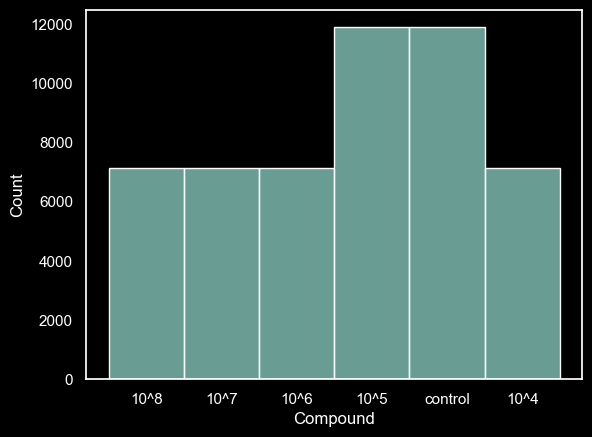

In [140]:
sns.histplot(data.Compound)

In [141]:
X = data.drop(columns=['Compound'])
y = data['Compound']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

under_sampler = RandomUnderSampler(random_state=1)
X_train, y_train = under_sampler.fit_resample(X_train, y_train)
print("Разделение по классам после UnderSampling:", Counter(y_train))

Разделение по классам после UnderSampling: Counter({'10^4': 5672, '10^5': 5672, '10^6': 5672, '10^7': 5672, '10^8': 5672, 'control': 5672})


In [142]:
# Scalers
mms = MinMaxScaler()
rs = RobustScaler()
ner = Normalizer()

X_train_mms = mms.fit_transform(X_train) 
X_test_mms = mms.fit_transform(X_test)

X_train_rs = rs.fit_transform(X_train) 
X_test_rs = rs.fit_transform(X_test)

X_train_ner = ner.fit_transform(X_train) 
X_test_ner = ner.fit_transform(X_test)


In [143]:
for mod in model_list:
    train_model(mod, X_train_mms, y_train, X_test_mms, y_test)

# RandomForestClassifier() 
_________________________ 
Accuracy_score: 0.37538197097020626 
Recall: 0.36470217118897597 
Precision: 0.4096374845536863 
F1-score: 0.3328281801864714 

# ExtraTreesClassifier() 
_________________________ 
Accuracy_score: 0.4065126050420168 
Recall: 0.3949251735180013 
Precision: 0.4292705140987334 
F1-score: 0.3534193348980956 

# SVC() 
_________________________ 
Accuracy_score: 0.34893048128342247 
Recall: 0.36916767617128077 
Precision: 0.573284596311288 
F1-score: 0.3727905087645144 

# LogisticRegression() 
_________________________ 
Accuracy_score: 0.33852177234530173 
Recall: 0.3207988522741594 
Precision: 0.48791943030246593 
F1-score: 0.230015776551067 



> Как оказалось, невозможно определить концетрацию бактерии без понятия о том, какого типа бактерия предоставлена модели

___

# Результат

Лучшей моделью оказалась модель "Catboost Classifier", с точностью около:

$ Accuracy = 0.99544289, $ 
$ F1_{score} = 0.99253257 $

### Почему "Catboost Classifier", если "Extra Trees Classifier" имеет точность выше?

Возможно, что, из-за недостаточной обширности данных, переобучение не сильно влияет на точность, а, даже, наоборот
помогает улучшить точность.

Если учесть, что такое вряд может быть и не возможно в "полевых условиях", то стоит выбрать CBC в качестве
модели для предсказания, так как CBC менее уязвим к переобучению.

# График точностей

Стоит учесть, что разница в точностях между моделями - от 0.002 до 0.0002

<img src="images/Screenshot_1.png">